In [32]:
import numpy as np
from scipy import sparse
import networkx as nx
import qutip as qt
import matplotlib.pyplot as plt

In [13]:
def Jij_instance(N, seed):
    """Generates an random instance of couplings - bimodal - even ferro and anti-ferro"""

    np.random.seed(seed)

    num_of_bonds = (N * (N - 1)) // 2
    if N % 4 == 0:
        a1 = [-1 for i in range(num_of_bonds // 2)]
    else:
        a1 = [-1 for i in range((num_of_bonds // 2) + 1)]
    a2 = [1 for i in range(num_of_bonds // 2)]
    a = list(np.random.permutation(a1 + a2))
    Jij = [a[(N * j) : N * (j + 1)] for j in range(N // 2)]
    if N % 2 == 0:
        Jij[(N // 2) - 1] += Jij[(N // 2) - 1]
    Jij = np.array(Jij)
    return Jij


def JZZ_SK_ME(N,J):
    """ Computes matrix elements for the SK interactions
        and returns each as a 1D np.array
        --JZZ = sum_{i,j} J_{ij}sigma^z_i sigma^z_j"""
    

    JZZ = np.zeros(2**N)
    shift_state = np.zeros(N,dtype=int)
    for b in range(2**N):
        state = 2*np.array(list(bin(b)[2:].zfill(N))).astype(int) - 1
        for shift in range(1,N//2+1):
            shift_state[shift:] = state[:-shift]
            shift_state[:shift] = state[-shift:]
            if (N%2 == 0) and (shift == N//2):
                JZZ[b] = JZZ[b] + 0.5*np.dot(J[shift-1,:]*shift_state,state)
            else:
                JZZ[b] = JZZ[b] + np.dot(J[shift-1,:]*shift_state,state)

    return JZZ

def JZZ_SK(N,J):
    """Builds matrices for infinite range zz interactions
        and returns each as a scipy.sparse.coo_matrix
        --JZZ = sum_{i,j} J_{ij}sigma^z_i sigma^z_j"""
    JZZ_ME = JZZ_SK_ME(N,J)
    I = np.arange(2**N)
    return sparse.coo_matrix((JZZ_ME,(I,I)),shape=(2**N,2**N))

def hamming_distance(i:int,j:int,N:int) -> int:
    arr_i = np.array([int(s) for s in bin(i)[2:].zfill(N)])
    arr_j = np.array([int(s) for s in bin(j)[2:].zfill(N)])
    return int(np.sum(arr_i != arr_j))

def make_J_adj(Jij, N):
    """
    Turns Jij matrix from form built in tfim.py to Jij adjacency matrix where J[i][j] is the bond between spins i and j
    """
    J_adj = np.zeros((N, N))
    for j in range(N // 2):
        for i in range(N):
            J_adj[i][(i - j + N - 1) % N] = J_adj[(i - j + N - 1) % N][i] = Jij[j][i]
    return J_adj


In [80]:



N = 8
max_h_d_list = []
supp_ratio_list = []
for seed in range(0,10000):
    # Get an instance
    Jij = Jij_instance(N,seed)
    JZZ = JZZ_SK(N, Jij)
    true_gs = np.where(JZZ.diagonal() == JZZ.diagonal().max())[0]

    # Pull out half of the ground states and determine maximum hd
    dim = len(true_gs)

    if dim == 2:
        # we only want to look at deg 4 and higher
        continue

    maximal_clique_len = 0
    max_h_d = 0
    h_d_cap = N/2
    while maximal_clique_len < dim/2:
        
        Aij = np.zeros((dim,dim))
        for i in range(dim):
            for j in range(i+1,dim):
                h_d = hamming_distance(true_gs[i],true_gs[j],N)
                if h_d <= h_d_cap:
                    Aij[i][j] = Aij[j][i] = np.exp(-h_d)
                    if h_d > max_h_d:
                        max_h_d = h_d
                


        h_d_cap += 1
        maximal_clique = max(nx.find_cliques(nx.Graph(Aij)), key=len)
        maximal_clique_len = len(maximal_clique)


    reduced_gs = [true_gs[i] for i in maximal_clique]


    max_h_d_list.append(max_h_d)

    # Determine ratio of suppression


    ## Get j adjacency matrix

    J_adj = make_J_adj(Jij, N)


    si = qt.qeye(2)
    sz = qt.sigmaz()

    ## Problem Hamiltonian
    ## Hp = -sum(Jij sigma_i_z sigma_j_z)

    Hp = 0
    for i in range(len(J_adj)):
        for j in range(i,len(J_adj[i])):

            sigma_i = [si if k != i else sz for k in range(N) ]
            sigma_j = [si if l != j else sz for l in range(N) ]

            Hp += J_adj[i][j] * qt.tensor(sigma_i) * qt.tensor(sigma_j)   

    ## transverse field hamiltonian
            
    sx = qt.sigmax()

    Ht = 0
    for i in range(N):
        sigma_x = [si if k != i else sx for k in range(N)]
        Ht += qt.tensor(sigma_x)





    total_time = 1000
    steps = 100

    taulist = np.linspace(0, total_time, steps)

    ## Initialize in equal superposition
    psi_list = [(1/np.sqrt(2))*(qt.basis(2,0) + qt.basis(2,1)) for n in range(N)]
    psi0 = qt.tensor(psi_list)


    ## the time-dependent hamiltonian in list-function format
    args = {"t_max": max(taulist)}
    h_t = [
        [-Ht, lambda t, args: (args["t_max"] - t) / args["t_max"]],
        [-Hp, lambda t, args: t / args["t_max"]],
    ]

    ## transform Hamiltonian to QobjEvo
    h_t = qt.QobjEvo(h_t, args=args)

    res = qt.sesolve(h_t, psi0, taulist, [], args)
    final_state = [(x.real**2 + x.imag**2)[0] for x in  res.states[-1].full()]
    gs_probs = []
    total_prob = 0
    for i, gs in enumerate(reduced_gs):
        gs_probs.append(2*final_state[gs])
        total_prob += 2*final_state[gs]

    # print(gs_probs)
    # print(total_prob)
    if abs(total_prob-1) > 1e-4:
        print(f"seed {seed} annealing fail. Total prob {total_prob}")
    suppression_ratio = min(gs_probs) / max(gs_probs)
    supp_ratio_list.append(1-suppression_ratio)
print(max_h_d_list)
print(supp_ratio_list)

[4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 4, 2, 4, 4, 2, 2, 2, 4, 4, 2, 2, 2, 4, 4, 4, 4, 4, 2, 2, 4, 6, 2, 2, 4, 4, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 6, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 2, 4, 2, 6, 4, 2, 2, 4, 2, 4, 2, 2, 4, 4, 2, 2, 2, 4, 2, 4, 2, 4, 4, 2, 2, 2, 2, 4, 4, 2, 4, 4, 4, 2, 4, 2, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 4, 2, 2, 2, 4, 2, 2, 4, 2, 4, 2, 6, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 2, 2, 2, 2, 4, 4, 2, 4, 2, 4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 6, 4, 2, 2, 2, 4, 4, 4, 4, 2, 4, 4, 2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 2, 4, 4, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 4, 2, 2, 6, 2, 2, 2, 2, 2, 2, 6, 4, 4, 2, 2, 2, 2, 4, 4, 4, 4, 4, 2, 2, 2, 4, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 2, 4, 2, 2, 2, 2, 4, 4, 2, 2, 4, 2, 2, 2, 2, 6, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 6, 2, 6, 4, 2, 2, 2, 2, 4, 4, 2, 4, 2, 4, 2, 

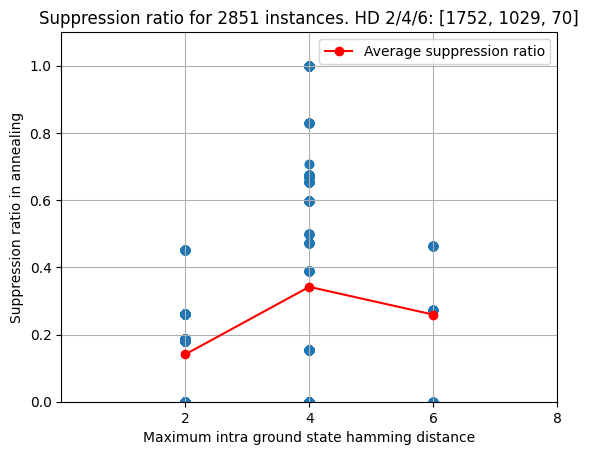

In [81]:

plt.scatter(max_h_d_list, supp_ratio_list) 
plt.xlabel('Maximum intra ground state hamming distance')
plt.ylabel('Suppression ratio in annealing')
plt.grid(True)  # Add grid
plt.xlim(0,6)
plt.ylim(0,1.1)
plt.xticks(range(2,10,2))

max_h_d_list = np.array(max_h_d_list)
supp_ratio_list = np.array(supp_ratio_list)

avg_supp = [np.mean(supp_ratio_list[max_h_d_list == i]) for i in [2,4,6]]
plt.plot([2,4,6], avg_supp, color='red', label='Average suppression ratio', marker = 'o')

plt.title(f"Suppression ratio for {len(max_h_d_list)} instances. HD 2/4/6: {[len(supp_ratio_list[max_h_d_list == i]) for i in [2,4,6]]}")
plt.legend()
plt.show()

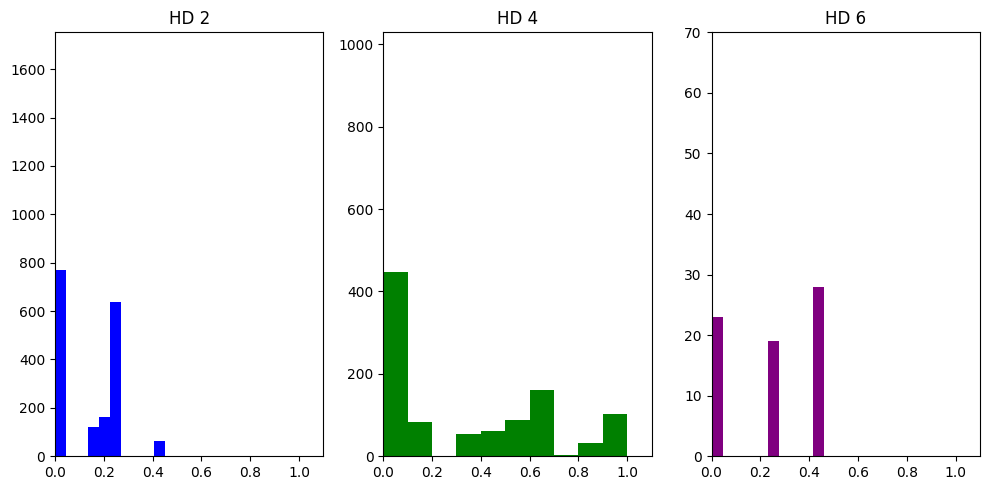

In [85]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns

# Plot histogram 1
h_d_2 = [supp_ratio_list[i] for i in range(len(max_h_d_list)) if max_h_d_list[i] == 2]
axs[0].hist(h_d_2, color='blue')
axs[0].set_title('HD 2')
axs[0].set_xlim(0,1.1)
axs[0].set_ylim(0,1752)

# Plot histogram 2
h_d_4 = [supp_ratio_list[i] for i in range(len(max_h_d_list)) if max_h_d_list[i] == 4]
axs[1].hist(h_d_4,color='green')
axs[1].set_title('HD 4')
axs[1].set_xlim(0,1.1)
axs[1].set_ylim(0,1029)

# Plot histogram 3
h_d_4 = [supp_ratio_list[i] for i in range(len(max_h_d_list)) if max_h_d_list[i] == 6]
axs[2].hist(h_d_4,color='purple')
axs[2].set_title('HD 6')
axs[2].set_xlim(0,1.1)
axs[2].set_ylim(0,70)

# Adjust layout
plt.tight_layout()

plt.show()

In [102]:

print(len(max_h_d_list))
[(i,supp_ratio_list[i]) for i in range(len(max_h_d_list)) if max_h_d_list[i] == 2 and supp_ratio_list[i]> 0.3]
# supp_ratio_list[max_h_d_list == 2][:25]

2851


[(17, 0.4518883702565861),
 (137, 0.45188837025230444),
 (149, 0.4516886244074887),
 (299, 0.45168862441064705),
 (323, 0.45168862440874824),
 (373, 0.45188837025319495),
 (466, 0.4516886244111209),
 (478, 0.4516886244233955),
 (511, 0.4516886244034535),
 (616, 0.45168862440850555),
 (620, 0.45168862441280055),
 (645, 0.4516886244146463),
 (652, 0.4514931906377596),
 (694, 0.4516886244103907),
 (706, 0.4516886244156191),
 (785, 0.4514931906447378),
 (819, 0.4516886244190974),
 (906, 0.4516886244131224),
 (929, 0.4516886244008158),
 (948, 0.4516886244138012),
 (992, 0.45149319064329485),
 (1021, 0.45168862440305946),
 (1059, 0.45188837028040785),
 (1071, 0.45149319065163773),
 (1090, 0.45149319064126825),
 (1098, 0.4516886244028575),
 (1134, 0.4514931906447309),
 (1176, 0.4514931906466678),
 (1354, 0.4516886244157188),
 (1386, 0.45168862441776536),
 (1398, 0.4516886244117386),
 (1425, 0.45168862441254676),
 (1451, 0.45188837027398887),
 (1452, 0.4516886244113605),
 (1476, 0.451888370253

In [108]:
count = 0
for seed in range(0,1000):
    if count == 137:
        print(seed)
    # Get an instance
    Jij = Jij_instance(N,seed)
    JZZ = JZZ_SK(N, Jij)
    true_gs = np.where(JZZ.diagonal() == JZZ.diagonal().max())[0]

    # Pull out half of the ground states and determine maximum hd
    dim = len(true_gs)

    if dim == 2:
        # we only want to look at deg 4 and higher
        continue
    
    count += 1




511


In [109]:
# Get an instance
seed = 511
Jij = Jij_instance(N,seed)
JZZ = JZZ_SK(N, Jij)
true_gs = np.where(JZZ.diagonal() == JZZ.diagonal().max())[0]

# Pull out half of the ground states and determine maximum hd
dim = len(true_gs)

maximal_clique_len = 0
max_h_d = 0
h_d_cap = N/2
while maximal_clique_len < dim/2:
    
    Aij = np.zeros((dim,dim))
    for i in range(dim):
        for j in range(i+1,dim):
            h_d = hamming_distance(true_gs[i],true_gs[j],N)
            if h_d <= h_d_cap:
                Aij[i][j] = Aij[j][i] = np.exp(-h_d)
                if h_d > max_h_d:
                    max_h_d = h_d
            


    h_d_cap += 1
    maximal_clique = max(nx.find_cliques(nx.Graph(Aij)), key=len)
    maximal_clique_len = len(maximal_clique)


reduced_gs = [true_gs[i] for i in maximal_clique]

# Determine ratio of suppression


## Get j adjacency matrix

J_adj = make_J_adj(Jij, N)


si = qt.qeye(2)
sz = qt.sigmaz()

## Problem Hamiltonian
## Hp = -sum(Jij sigma_i_z sigma_j_z)

Hp = 0
for i in range(len(J_adj)):
    for j in range(i,len(J_adj[i])):

        sigma_i = [si if k != i else sz for k in range(N) ]
        sigma_j = [si if l != j else sz for l in range(N) ]

        Hp += J_adj[i][j] * qt.tensor(sigma_i) * qt.tensor(sigma_j)   

## transverse field hamiltonian
        
sx = qt.sigmax()

Ht = 0
for i in range(N):
    sigma_x = [si if k != i else sx for k in range(N)]
    Ht += qt.tensor(sigma_x)





total_time = 1000
steps = 100

taulist = np.linspace(0, total_time, steps)

## Initialize in equal superposition
psi_list = [(1/np.sqrt(2))*(qt.basis(2,0) + qt.basis(2,1)) for n in range(N)]
psi0 = qt.tensor(psi_list)


## the time-dependent hamiltonian in list-function format
args = {"t_max": max(taulist)}
h_t = [
    [-Ht, lambda t, args: (args["t_max"] - t) / args["t_max"]],
    [-Hp, lambda t, args: t / args["t_max"]],
]

## transform Hamiltonian to QobjEvo
h_t = qt.QobjEvo(h_t, args=args)

res = qt.sesolve(h_t, psi0, taulist, [], args)
final_state = [(x.real**2 + x.imag**2)[0] for x in  res.states[-1].full()]
gs_probs = []
total_prob = 0
for i, gs in enumerate(reduced_gs):
    gs_probs.append(2*final_state[gs])
    total_prob += 2*final_state[gs]

# print(gs_probs)
# print(total_prob)
if abs(total_prob-1) > 1e-4:
    print(f"seed {seed} annealing fail. Total prob {total_prob}")
suppression_ratio = 1 - (min(gs_probs) / max(gs_probs))

print(J_adj)
print(true_gs)
print(reduced_gs)
print(max_h_d)
print(gs_probs)
print(suppression_ratio)

[[ 0. -1.  1. -1. -1.  1. -1. -1.]
 [-1.  0.  1. -1.  1. -1.  1. -1.]
 [ 1.  1.  0.  1. -1. -1. -1. -1.]
 [-1. -1.  1.  0.  1.  1.  1.  1.]
 [-1.  1. -1.  1.  0. -1.  1.  1.]
 [ 1. -1. -1.  1. -1.  0. -1.  1.]
 [-1.  1. -1.  1.  1. -1.  0.  1.]
 [-1. -1. -1.  1.  1.  1.  1.  0.]]
[ 31  91 164 224]
[31, 91]
2
[0.354051576238914, 0.6459479365579043]
0.45188837025230444
